## This notebook is to create future river forcing from three components: CLM, HF, and time-varying delta 
* how each component was made, please see **"create_45_rivers_forcing_01.ipynb"**

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

from lo_tools import Lfun
Ldir = Lfun.Lstart()

### 1. Read the historical climatology (CLM) (1993-2022)



In [2]:
# define path to read files from
in_dir = Ldir['LOo'] / 'forcing' / 'cas2k' / 'river'
# read the Climatology (day of year)
ds = xr.open_dataset(f'{in_dir}/climatology/river_flow_CLM.nc')
# read the historical time-series daily forcing (1993-2022) as well 
hist = xr.open_dataset(f'{in_dir}/river_historical_1993-2022.nc')

In [3]:
# define path to save figures
fig_dir = Ldir['LOo'] / 'forcing' / 'cas2k' / 'river' /'plot'
Lfun.make_dir(fig_dir)

### 2. Read time-series High Frequency river forcing component (HF)

In [4]:
dt = xr.open_dataset(f'{in_dir}/climatology/river_flow_high_freq.nc')

### 3. Get the time-varying delta
* use the time series of percentage change × (CLM_1993-2022)

In [5]:
# read daily delta_percent_change from GFDL ESM4.0
percent = xr.open_dataset(f'{in_dir}/climatology/river_flow_percent_change_daily.nc')

In [6]:
# CLM only has 366 day of year, broadcast the CLM for the whole time period, 
CLM_1993_2022 = ds['river_transport'].sel(dayofyear=dt['river_time'].dt.dayofyear)
CLM_1993_2022 = CLM_1993_2022.rename("river_clm")
HF_1993_2022 = dt['river_hf']

In [7]:
start = percent['time'][0].dt.year.values
end = percent['time'][-1].dt.year.values
num_years = end - start + 1  # Total years to extend
CLM = CLM_1993_2022.rename({'river_time': 'time'})
CLM_extended = xr.concat([CLM] * (num_years // 30 + 1), dim="time").isel(time=slice(0, len(percent.time)))
# replace the time for future period
CLM_extended = CLM_extended.assign_coords(time=percent.time)

In [8]:
# calculate the time-varing delta
delta = percent['percent_change']*0.01 * CLM_extended 

### 4. Calculate the future forcing

In [9]:
# get the sum, (CLM_1993_2022 + HF_1993_2022) and rename the time coordinate 
sum = (CLM_1993_2022 + HF_1993_2022).rename({'river_time': 'time'})

# Extend 'sum' (1993-2022) to match the 2023-2100 period
sum_extended = xr.concat([sum] * (num_years // 30 + 1), dim="time").isel(time=slice(0, len(percent.time)))

# replace the time using future time-series 
sum_extended = sum_extended.assign_coords(time=percent.time)

In [10]:
# finally the future forcing 
fut_2023_2100 = sum_extended + delta

In [11]:
FUT_2023_2100 = fut_2023_2100.to_dataset(name="future_flow")
SUM_extended = sum_extended.to_dataset(name="clm_hf_flow")
future = xr.merge([FUT_2023_2100, SUM_extended])

In [12]:
# Plot the historical + future change over time
num_river = np.size(sum['river'])
for i in np.arange(1,num_river+1):    
    mean_future = np.mean(future['future_flow'].sel(river =i).values)     
    mask1 = (mean_future > 0) & (future['future_flow'].sel(river=i) < 0)
    mask2 = (mean_future < 0) & (future['future_flow'].sel(river=i) > 0)
    # Replace values where mask1 is True
    future['future_flow'].loc[dict(river=i)] = xr.where(mask1 | mask2, future['clm_hf_flow'].sel(river=i), future['future_flow'].sel(river=i))
    

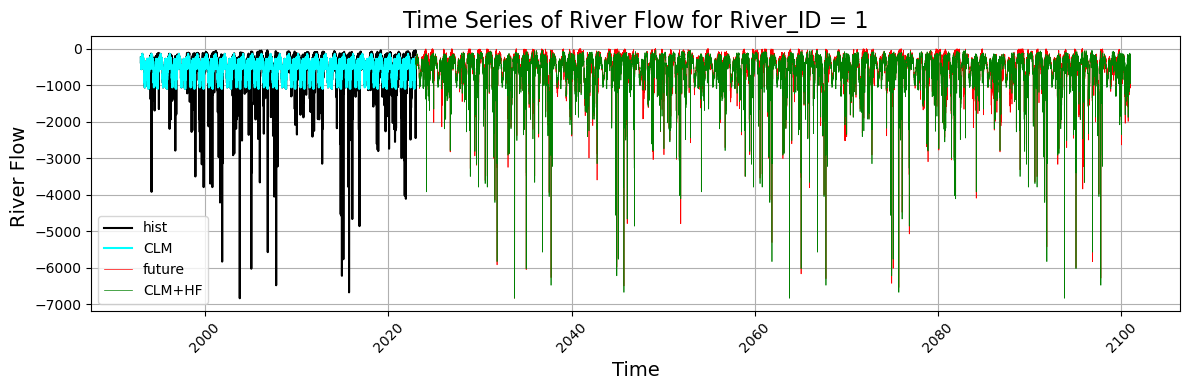

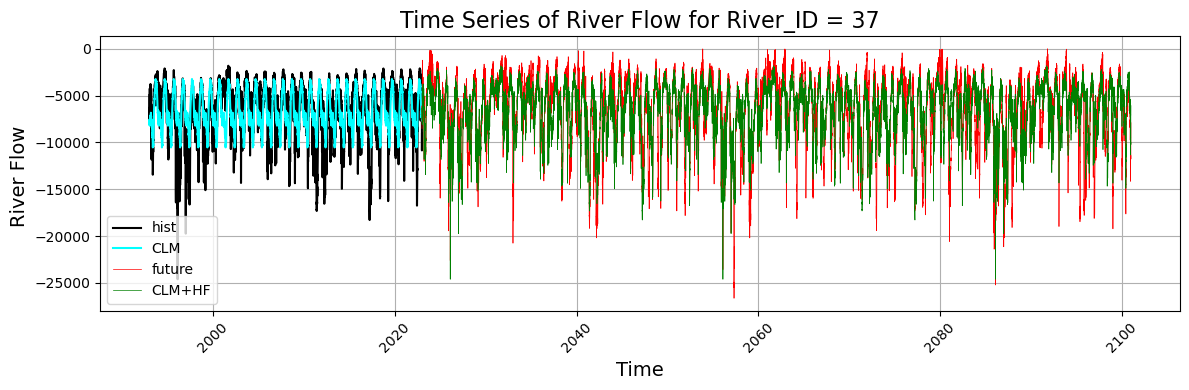

In [13]:
for i in np.arange(1,num_river+1):
    # print(i)
    plt.figure(figsize=(12, 4))
    plt.plot(hist.river_time.values, hist['river_transport'].sel(river =i).values, marker='o', markersize=0,  color='k',linestyle= '-', label='hist')
    # plt.plot(sum.time.values, sum.sel(river =i), marker='o',  markersize=0, color='gray',linestyle= '-', label='CLM+HF')    
    # plt.plot(HF_1993_2022.river_time.values, HF_1993_2022.sel(river =i), marker='.', markersize=0, color='pink',linestyle= '-', label='HF')
    plt.plot(CLM_1993_2022.river_time.values, CLM_1993_2022.sel(river =i), marker='.', markersize=0, color='cyan',linestyle= '-', label='CLM')
    # plt.plot(fut_2023_2100.time.values, fut_2023_2100.sel(river =i), marker='o', markersize=0,color='blue', linestyle= '-', linewidth=0.5, label='future')
    plt.plot(future.time.values, future['future_flow'].sel(river =i), marker='o', markersize=0, color='red', linestyle= '-', linewidth=0.5, label='future')
    plt.plot(SUM_extended.time.values, SUM_extended['clm_hf_flow'].sel(river =i), marker='o', markersize=0, color='green', linestyle= '-', linewidth=0.5, label='CLM+HF')
    # Add labels and title
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('River Flow ', fontsize=14)
    plt.title(f'Time Series of River Flow for River_ID = {i}', fontsize=16)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.tight_layout()
    # ffn = f"{fig_dir}/future_river_forcing_at_River_ID={i}.png"
    # plt.savefig(ffn)
    if i == 1 or i == 37:
        plt.show() # Show the plot  
    else:
        plt.close()
